In [61]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import seaborn as sns


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'



In [62]:
### load the dirs
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [63]:
### specify the model
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label
    
### create instance of model
nn_model = TripletLabelModel()

In [64]:
### load in validation images and labels
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

## load in the trained model weights and store in a list
model_list = os.listdir(results_dir)
model_list = sorted(model_list)

In [65]:
model_list
### get all items in model_list that begin with 0
m = [i for i in model_list if i.startswith('0')]
m

['0_set_A2_label.pth',
 '0_set_A2_label_and_triplet.pth',
 '0_set_A2_triplet.pth',
 '0_set_A_label.pth',
 '0_set_A_label_and_triplet.pth',
 '0_set_A_triplet.pth',
 '0_set_B_label.pth',
 '0_set_B_label_and_triplet.pth',
 '0_set_B_triplet.pth',
 '0_set_C_label.pth',
 '0_set_C_label_and_triplet.pth',
 '0_set_C_triplet.pth']

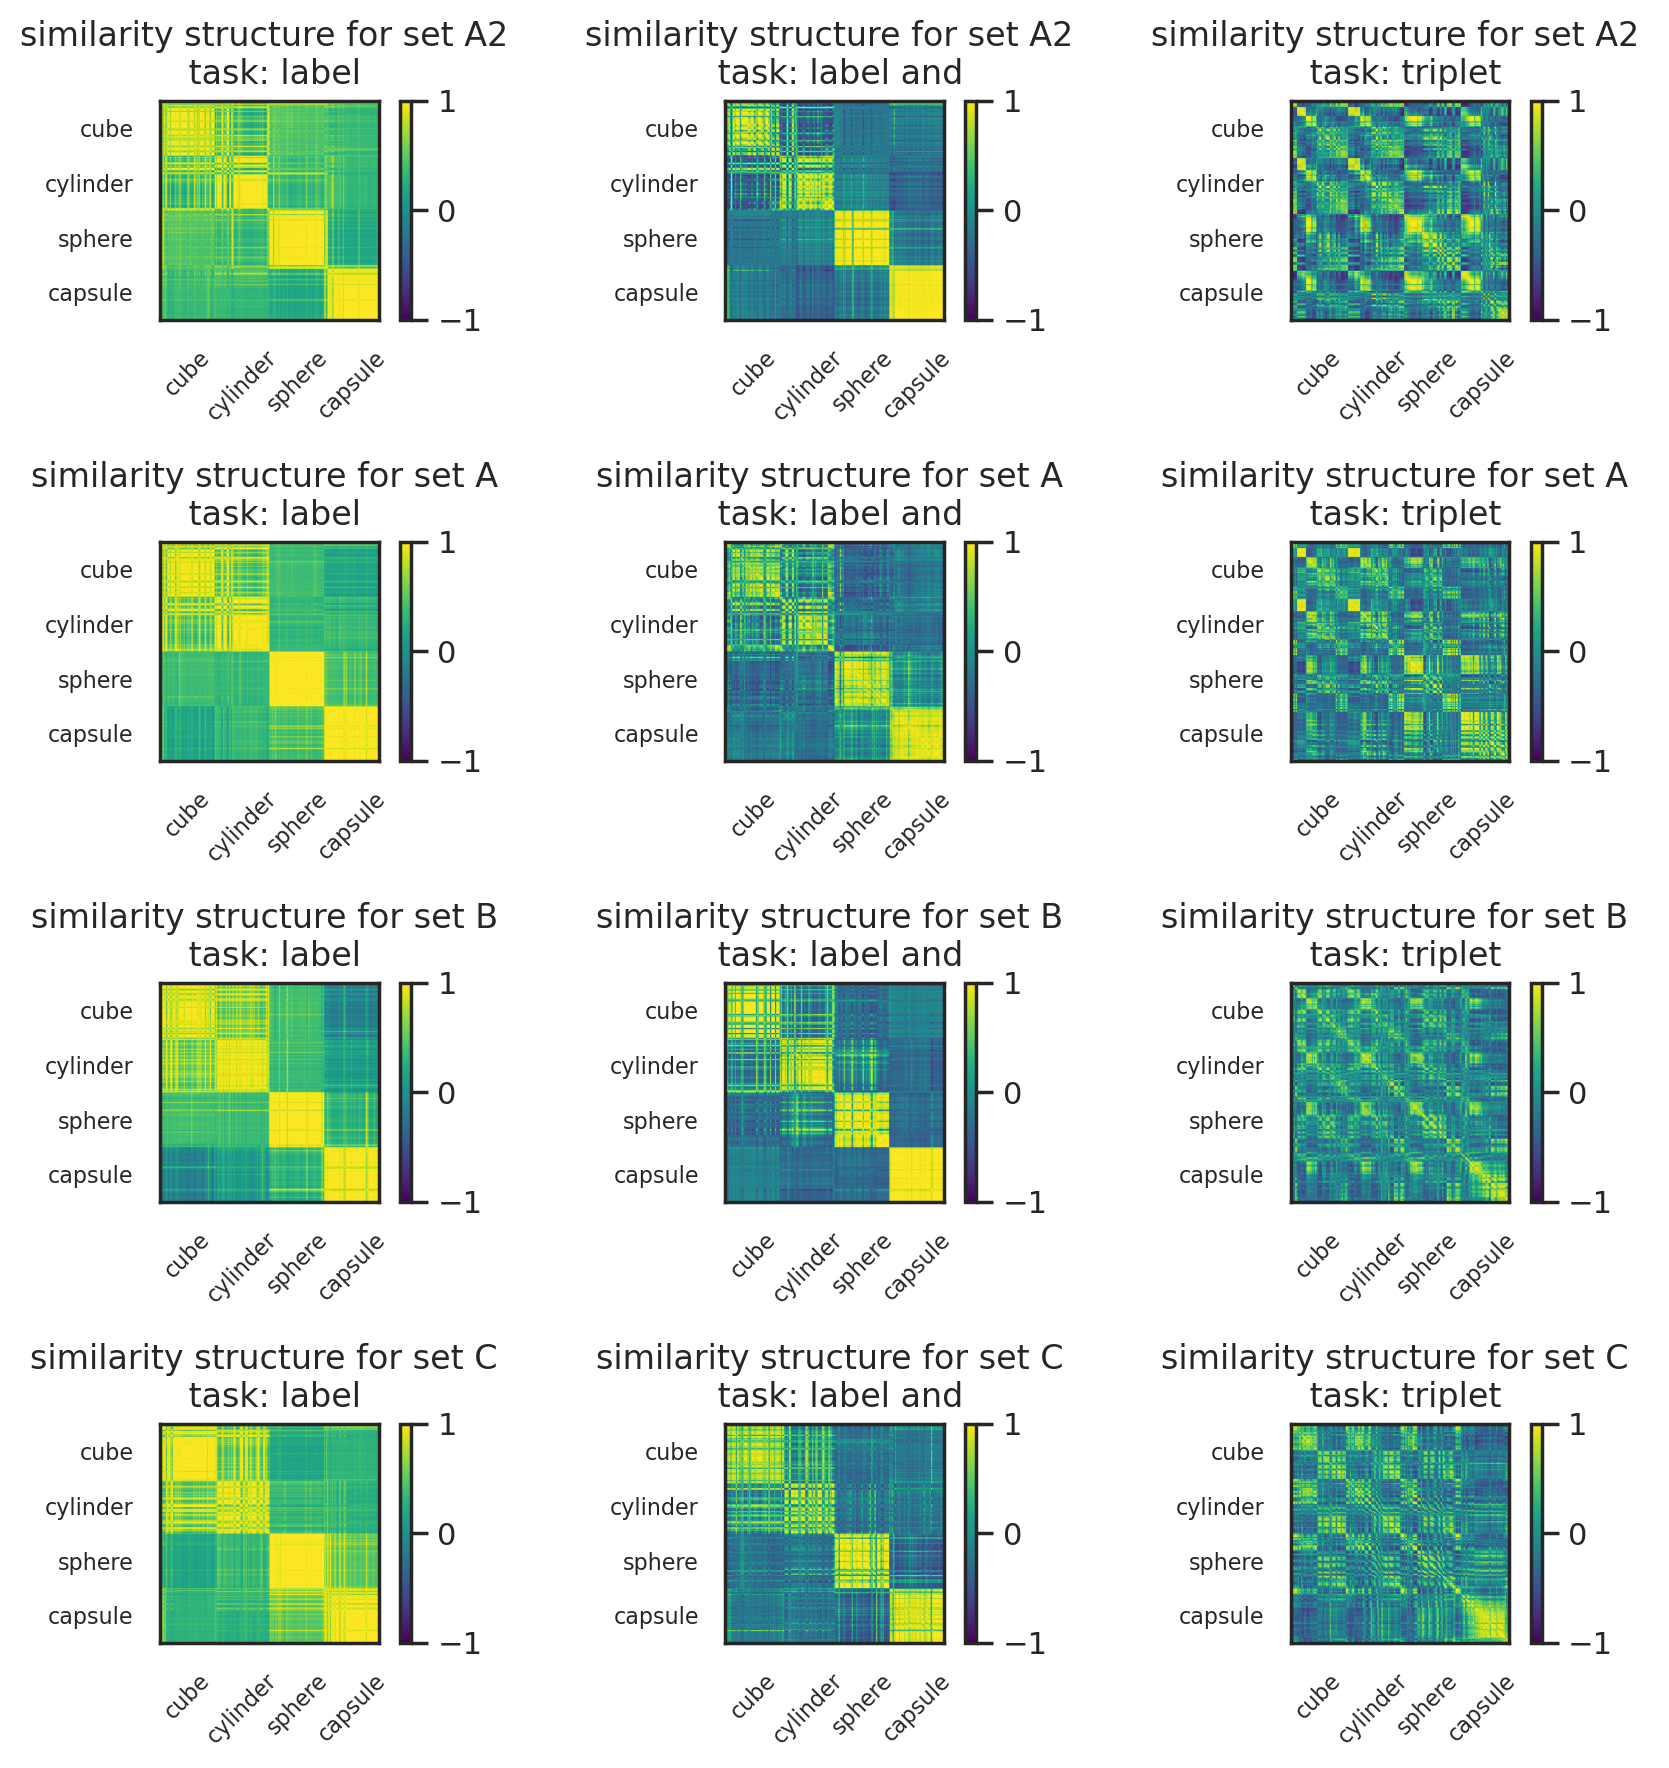

In [103]:
### load in each model and compute the accuracy on the validation set

nmodels= 10
accs = []
tasks = []
dsets = []
iters = []
cat_scores = []
latents_df =pd.DataFrame(columns=['dataset','task','latent','iter'])
fig, axes = plt.subplots(4,3,figsize=(9,9))

for iter in range(nmodels):
    m_sub = [k for k in model_list if k.startswith(str(iter))]
    for i, this_model in enumerate(m_sub):
        ax = axes.flatten()[i]
        nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
        # nn_model.load_state_dict(torch.load(cifar_model))
        ### pass v_ims through the model but make sure to transpose the image dimensions first
        v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
        v_ims_t = v_ims_t/255.0
        v_ims_t = Resize(32)(v_ims_t)

        ### now pass v_ims through the model
        latents, labels = nn_model(v_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels = torch.argmax(labels,dim=1)
        pred_labels = pred_labels.detach().numpy()

        correct = 0
        for j in range(len(pred_labels)):
            if pred_labels[j] == v_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        accs.append(correct/len(pred_labels))
        tasks.append(this_model.split('_', 3)[3].rsplit('.', 1)[0])
        dsets.append(this_model.split("_")[2])
        iters.append(iter)


        dist = pdist(latents.detach().numpy())
        blocksize = 120
        block_diag = np.zeros((480,480))
        for l in range(4):
            block_diag[l*blocksize:(l+1)*blocksize,l*blocksize:(l+1)*blocksize] = 1

        ### mask distA with block_diag
        within_dist = squareform(dist)*block_diag
        between_dist = squareform(dist)*(1-block_diag)

        categoricality = np.log(np.mean(between_dist)/np.mean(within_dist))
        cat_scores.append(categoricality)


        # Compute pairwise cosine similarities
        cos_sim = cosine_similarity(latents.detach().numpy())

        # Plot heatmap
        im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
        cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        cbar.set_ticks([-1,0,1])


        ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
        ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



        task_string = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


    
        ax.set_title(f'similarity structure for set {this_model.split("_")[2]} \n task: {task_string}')
        

        fig.tight_layout()

        latents_df.loc[(nmodels*i)+iter,'dataset'] = this_model.split("_")[2]
        latents_df.loc[(nmodels*i)+iter,'task'] = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        latents_df.loc[(nmodels*i)+iter,'latent'] = latents.detach().numpy()
        latents_df.loc[(nmodels*i)+iter,'iter'] = iter
        # latents_df.loc[(nmodels*i)+iter,'categoricality'] = categoricality
        

    plt.show()
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs,'dataset':dsets, 'iter':iters,'categoricality':cat_scores})



,task,accuracy,dataset,iter,categoricality
0,label,0.875000,A2,0,1.976747
1,label_and_triplet,0.916667,A2,0,2.004534
2,triplet,0.191667,A2,0,1.179014
3,label,0.922917,A,0,2.177686
4,label_and_triplet,0.858333,A,0,1.672303
...,...,...,...,...,...
115,label_and_triplet,0.860417,B,9,1.726683
116,triplet,0.245833,B,9,1.165711
117,label,0.916667,C,9,2.214297
118,label_and_triplet,0.845833,C,9,1.741182


In [67]:
sns.set_theme(style="white")

In [68]:
acc_df.to_csv(os.path.join(data_dir,'accuracy_data.csv'))

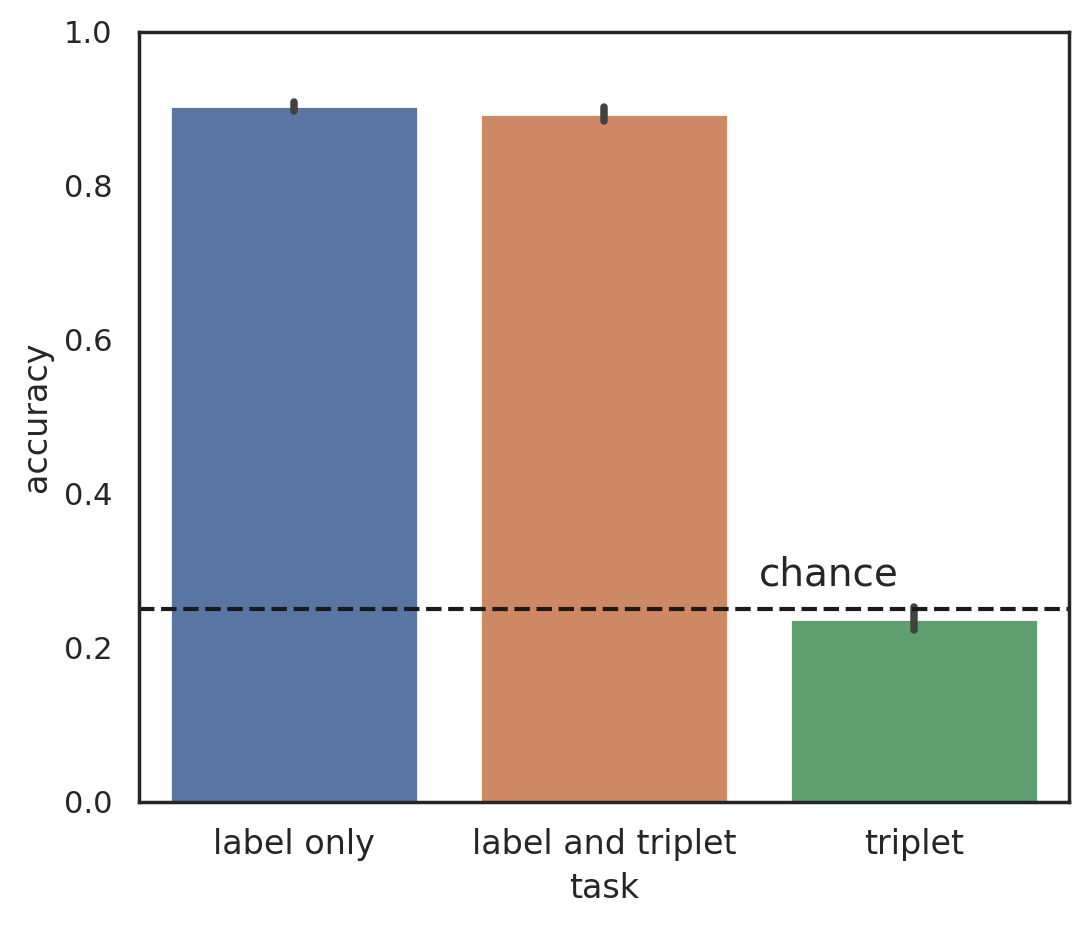

In [69]:
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='accuracy',data=acc_df)
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)

### set the x tick labels to be the task names
plt.xticks(range(3),['label only','label and triplet','triplet'],fontsize=12)
plt.ylim([0,1])
plt.savefig('accuracy_barplot.pdf',dpi=300, bbox_inches='tight')


In [70]:
latents_df

,dataset,task,latent,iter
0,A2,label,"[[-0.2219373, 2.2494845, 0.78841823, 1.3341645...",0
10,A2,label_and_triplet,"[[-0.27834535, -0.28118953, 0.21440706, 0.1317...",0
20,A2,triplet,"[[-2.346183, -0.20968872, 0.7601119, 1.1399821...",0
30,A,label,"[[1.841282, 1.440677, 0.45024624, 0.41042116, ...",0
40,A,label_and_triplet,"[[1.4040735, 0.25026938, 0.10856034, 0.1502518...",0
...,...,...,...,...
79,B,label_and_triplet,"[[0.5706371, 0.7276867, -0.09106099, -0.022883...",9
89,B,triplet,"[[1.6877229, -2.5214434, 0.7848092, -0.1197739...",9
99,C,label,"[[0.26072448, 0.2508362, 1.5580437, 0.11557171...",9
109,C,label_and_triplet,"[[-0.9788434, 1.1313938, 0.2750972, 0.83509696...",9


In [71]:
# latents_df = latents_df[latents_df['task']!='label']
latents_df.head()
# dss.latents


def compute_within_between_procrustes(mat1,mat2, items_per_cat=120):
    within_procrustes = []
    between_procrustes = []
    assert mat1.shape == mat2.shape
    for i in range(int(mat1.shape[0]/items_per_cat)):
        # print('i',i)
        mat1_sub = mat1[i*items_per_cat:(i+1)*items_per_cat,:]
    
        mat2_sub = mat2[i*items_per_cat:(i+1)*items_per_cat,:]
        ### get all the rows in mat2 not in mat2_sub using array indexing

        mat2_sub_c = mat2[np.isin(mat2[:,0],mat2_sub[:,0],invert=True),:]

    
        within_procrustes.append(procrustes(mat1_sub,mat2_sub)[2])
        # print('mat_sub_c shape',mat2_sub_c.shape[0])
        for j in range(int(mat2_sub_c.shape[0]/items_per_cat)):
            # print('j',j)
            this_sub_mat2 = mat2_sub_c[j*items_per_cat:(j+1)*items_per_cat,:]
    
            between_procrustes.append(procrustes(mat1_sub,this_sub_mat2)[2])
            
            # print(procrustes(mat1_sub,this_sub_mat2)[2])
    mean_w_procrustes = np.mean(within_procrustes)
    mean_b_procrustes = np.mean(between_procrustes)
   
    return mean_w_procrustes, mean_b_procrustes
            
    

In [72]:

from scipy.spatial import procrustes

tasks=[]
overlaps = []
withins = []
betweens = []
proc_withins = []
proc_betweens = []
procruses = []
cat_scores_1 = []
cat_scores_2 = []
iters = []
m1s = []
m2s = []
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]
   for this_iter in ds['iter'].unique():
      dss = ds[ds['iter']==this_iter]
      distA = pdist(dss[dss.dataset=='A']['latent'].values[0], metric='cosine')
      distA2 = pdist(dss[dss.dataset=='A2']['latent'].values[0], metric='cosine')
      distB = pdist(dss[dss.dataset=='B']['latent'].values[0], metric='cosine')
      distC = pdist(dss[dss.dataset=='C']['latent'].values[0], metric='cosine')

      blocksize = 120
      block_diag = np.zeros((480,480))
      for i in range(4):
         block_diag[i*blocksize:(i+1)*blocksize,i*blocksize:(i+1)*blocksize] = 1

      ### mask distA with block_diag
      within_distA = squareform(distA)*block_diag
      between_distA = squareform(distA)*(1-block_diag)
      within_distA2 = squareform(distA2)*block_diag
      between_distA2 = squareform(distA2)*(1-block_diag)
      within_distB = squareform(distB)*block_diag
      between_distB = squareform(distB)*(1-block_diag)
      within_distC = squareform(distC)*block_diag
      between_distC = squareform(distC)*(1-block_diag)

      ### compute categoricality measures

      categoricality_A = np.log(np.mean(between_distA)/np.mean(within_distA))
      categoricality_A2 = np.log(np.mean(between_distA2)/np.mean(within_distA2))
      categoricality_B = np.log(np.mean(between_distB)/np.mean(within_distB))
      categoricality_C = np.log(np.mean(between_distC)/ np.mean(within_distC))





      ### compute distance matrices and get lower triangles
      dmatA_within = np.tril(within_distA,k=-1).flatten()
      dmatA2_within = np.tril(within_distA2,k=-1).flatten()
      dmatB_within = np.tril(within_distB,k=-1).flatten()
      dmatC_within = np.tril(within_distC,k=-1).flatten()
   
      dmatA_between = np.tril(between_distA,k=-1).flatten()
      dmatA2_between = np.tril(between_distA2,k=-1).flatten()
      dmatB_between = np.tril(between_distB,k=-1).flatten()
      dmatC_between = np.tril(between_distC,k=-1).flatten()

      ### remove all the zeros from the above 8 vectors 
      dmatA_within = dmatA_within[dmatA_within!=0]
      dmatA2_within = dmatA2_within[dmatA2_within!=0]
      dmatB_within = dmatB_within[dmatB_within!=0]
      dmatC_within = dmatC_within[dmatC_within!=0]
      dmatA_between = dmatA_between[dmatA_between!=0]
      dmatA2_between = dmatA2_between[dmatA2_between!=0]
      dmatB_between = dmatB_between[dmatB_between!=0]
      dmatC_between = dmatC_between[dmatC_between!=0]




      # AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
      # AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
      # BC_sim = np.corrcoef(dmatB,dmatC)[0,1]
      
      AB_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )[2]
      AC_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      BC_proc = procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      AA_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )[2]

      # AB_proc = procrustes(squareform(distA), squareform(distB) )[2]
      # AC_proc = procrustes(squareform(distA), squareform(distC) )[2]
      # BC_proc = procrustes(squareform(distB), squareform(distC) )[2]
      # AA_proc = procrustes(squareform(distA), squareform(distA2) )[2]

      # AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )
      # AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )

      # AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distB) )
      # AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distC) )
      # BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(squareform(distB), squareform(distC) )
      # AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distA2) )
      

   


      AB_within_sim = np.corrcoef(dmatA_within,dmatB_within)[0,1]
      AC_within_sim = np.corrcoef(dmatA_within,dmatC_within)[0,1]
      BC_within_sim = np.corrcoef(dmatB_within,dmatC_within)[0,1]
      AA_within_sim = np.corrcoef(dmatA_within,dmatA2_within)[0,1]

      AB_between_sim = np.corrcoef(dmatA_between,dmatB_between)[0,1]
      AC_between_sim = np.corrcoef(dmatA_between,dmatC_between)[0,1]
      BC_between_sim = np.corrcoef(dmatB_between,dmatC_between)[0,1]
      AA_between_sim = np.corrcoef(dmatA_between,dmatA2_between)[0,1]

      # print(f'{this_task} results')
      # print(f'AA within category similarity for {this_task} is {AA_within_sim}')
      # print(f'AB within category similarity for {this_task} is {AB_within_sim}')
      # print(f'AC within category similarity for {this_task} is {AC_within_sim}')
      # print(f'BC within category similarity for {this_task} is {BC_within_sim}')
      # print('')
      # print(f'AA between category similarity for {this_task} is {AA_between_sim}')
      # print(f'AB between category similarity for {this_task} is {AB_between_sim}')
      # print(f'AC between category similarity for {this_task} is {AC_between_sim}')
      # print(f'BC between category similarity for {this_task} is {BC_between_sim}')
      # print('')
      tasks.append([this_task]*4)
      overlaps.append([50,0,33.33,100])
      withins.append([AB_within_sim,AC_within_sim,BC_within_sim,AA_within_sim])
      betweens.append([AB_between_sim,AC_between_sim,BC_between_sim,AA_between_sim])
      procruses.append([AB_proc,AC_proc,BC_proc,AA_proc])
      # proc_withins.append([AB_proc_within,AC_proc_within,BC_proc_within,AA_proc_within])
      # proc_betweens.append([AB_proc_between,AC_proc_between,BC_proc_between,AA_proc_between])
      cat_scores_1.append([categoricality_A,categoricality_A,categoricality_B,categoricality_A])
      cat_scores_2.append([categoricality_B,categoricality_C,categoricality_C,categoricality_A2])
      iters.append([this_iter]*4)
      m1s.append([f'A{this_iter}',f'A{this_iter}',f'B{this_iter}',f'A{this_iter}'])
      m2s.append([f'B{this_iter}',f'C{this_iter}',f'C{this_iter}',f'A2{this_iter}'])






In [73]:
np.corrcoef(dmatA_between,dmatB_between)

array([[1.        , 0.30184514],
       [0.30184514, 1.        ]])

In [74]:
## remove the zeros from dmatA_between and dmatB_between
dmatA_between[dmatA_between==0] = np.nan
dmatB_between[dmatB_between==0] = np.nan
### remove all nans then compute the correlation
np.corrcoef(dmatA_between[~np.isnan(dmatA_between)],dmatB_between[~np.isnan(dmatB_between)])



array([[1.        , 0.30184514],
       [0.30184514, 1.        ]])

In [75]:
sim_df = pd.DataFrame({'m1': np.array(m1s).flatten(),'m2': np.array(m2s).flatten(),\
                        'task':np.array(tasks).flatten(), 'overlap':np.array(overlaps).flatten(),\
                       'within_cat_r':np.array(withins).flatten(),'between_cat_r':np.array(betweens).flatten(), \
                        'procrustes':np.array(procruses).flatten(), \
                        # 'proc_within':np.array(proc_withins).flatten(),'proc_between':np.array(proc_betweens).flatten(),\
                            'cat_score_1':np.array(cat_scores_1).flatten(),\
                             'cat_score_2':np.array(cat_scores_2).flatten(),'iter':np.array(iters).flatten() })
sim_df['mean_cat_score'] = (sim_df['cat_score_1'] + sim_df['cat_score_2'])/2    
# sim_df['procrustes_sim'] = 1/(sim_df['procrustes'])
sim_df['min_cat_score'] = np.min([sim_df['cat_score_1'],sim_df['cat_score_2']],axis=0)
sim_df.to_csv(os.path.join(data_dir,'alignment_data.csv'),index=False)


In [76]:
sim_df

,m1,m2,task,overlap,within_cat_r,between_cat_r,procrustes,cat_score_1,cat_score_2,iter,mean_cat_score,min_cat_score
0,A0,B0,label,50.00,0.325966,0.631553,0.250300,3.145897,3.287757,0,3.216827,3.145897
1,A0,C0,label,0.00,0.244992,0.454759,0.356802,3.145897,2.976447,0,3.061172,2.976447
2,B0,C0,label,33.33,0.285354,0.355558,0.379434,3.287757,2.976447,0,3.132102,2.976447
3,A0,A20,label,100.00,0.661796,0.425021,0.233203,3.145897,2.655586,0,2.900742,2.655586
4,A1,B1,label,50.00,0.370794,0.386929,0.411407,2.705431,3.051460,1,2.878445,2.705431
...,...,...,...,...,...,...,...,...,...,...,...,...
115,A8,A28,triplet,100.00,0.703709,0.648920,0.364869,1.224869,1.234270,8,1.229569,1.224869
116,A9,B9,triplet,50.00,0.327708,0.301845,0.657493,1.203721,1.197750,9,1.200735,1.197750
117,A9,C9,triplet,0.00,0.210690,0.118251,0.848763,1.203721,1.370324,9,1.287022,1.203721
118,B9,C9,triplet,33.33,0.262695,0.148487,0.794566,1.197750,1.370324,9,1.284037,1.197750


In [77]:
sim_df_m1 = sim_df.groupby(['task','m1']).mean().reset_index() 
sim_df_m2 = sim_df.groupby(['task','m2']).mean().reset_index()
## rename m1 and m2 columns to be the same
sim_df_m1 = sim_df_m1.rename(columns={'m1':'model'})
sim_df_m2 = sim_df_m2.rename(columns={'m2':'model'})
## combine sim_df_m1 and sim_df_m2 row-wise
sim_df_m = pd.concat([sim_df_m1,sim_df_m2],axis=0).groupby(['task','model']).mean().reset_index()
sim_df_m.to_csv(os.path.join(data_dir,'alignment_data_avg.csv'),index=False)



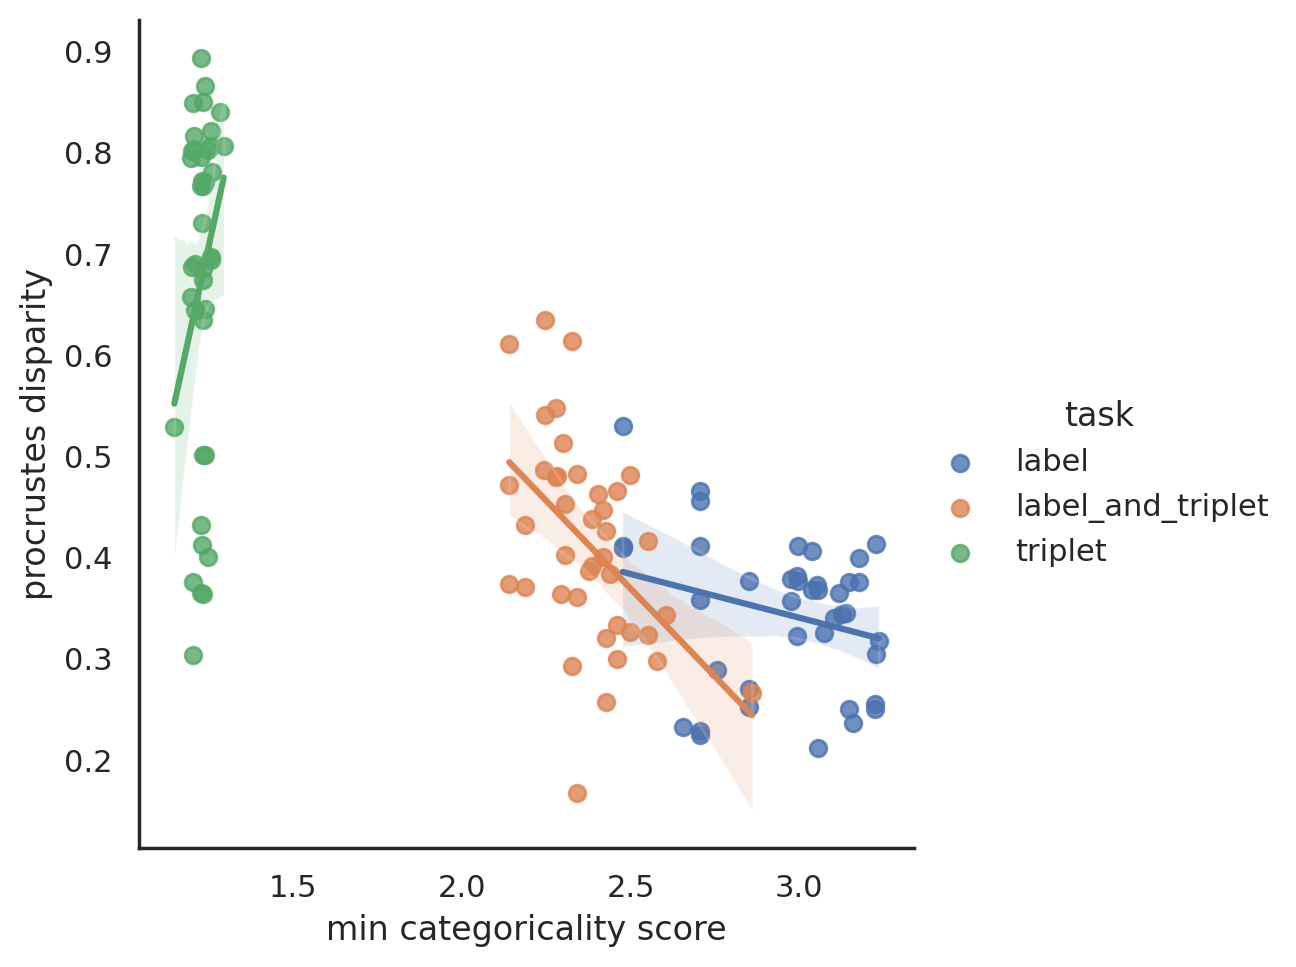

In [87]:
sns.lmplot(x='min_cat_score',y='procrustes',data=sim_df, hue='task',fit_reg=True,legend=True)
# plt.legend(loc='upper left')
plt.xlabel('min categoricality score')
plt.ylabel('procrustes disparity')
plt.savefig('procrustes_vs_cat.pdf',dpi=300, bbox_inches='tight')

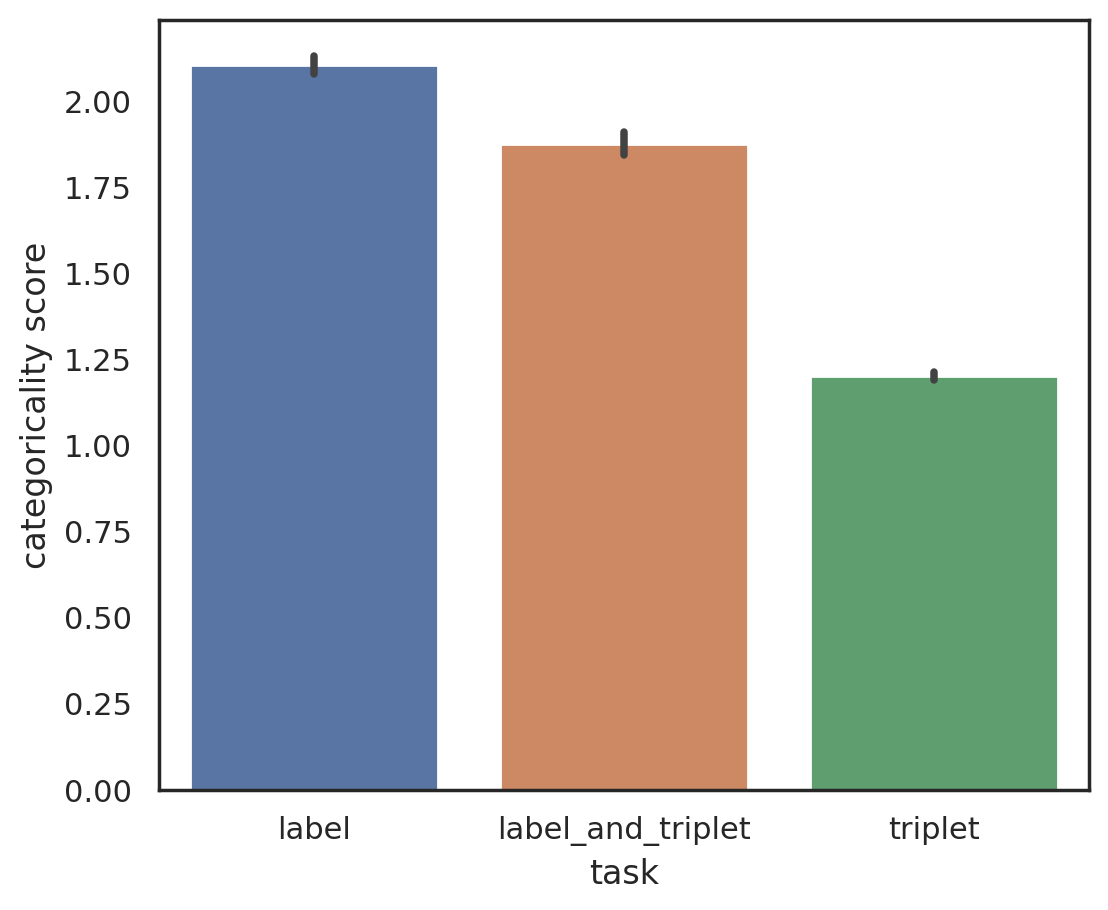

In [105]:
from scipy.stats import pearsonr
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='categoricality',data=acc_df)
plt.ylabel('categoricality score')
plt.xlabel('task')
plt.savefig('categoricality_barplot.pdf',dpi=300, bbox_inches='tight')


In [107]:
acc_df.groupby('task').describe()

accuracy                                                    \
                     count      mean       std       min       25%       50%   
task                                                                           
label                 40.0  0.902865  0.018154  0.866667  0.891146  0.900000   
label_and_triplet     40.0  0.892500  0.029451  0.835417  0.875000  0.891667   
triplet               40.0  0.236927  0.047432  0.143750  0.200000  0.239583   

                                       iter       ...            \
                        75%       max count mean  ...  75%  max   
task                                              ...             
label              0.914583  0.939583  40.0  4.5  ...  7.0  9.0   
label_and_triplet  0.912500  0.977083  40.0  4.5  ...  7.0  9.0   
triplet            0.259896  0.366667  40.0  4.5  ...  7.0  9.0   

                  categoricality                                          \
                           count      mean       std       min       25%   
task                                                                       
label                       40.0  2.105697  0.083867  1.874638  2.068047   
label_and_triplet           40.0  1.874796  0.103970  1.672303  1.801424   
triplet                     40.0  1.200987  0.034445  1.132767  1.179533   

                                                 
                        50%       75%       max  
task                                             
label              2.114263  2.159792  2.248365  
label_and_triplet  1.865207  1.943138  2.148832  
triplet            1.193781  1.209753  1.289118  

[3 rows x 24 columns]

In [109]:
sim_df.groupby('task')['procrustes'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
label,40.0,0.344468,0.074351,0.211819,0.284106,0.361975,0.386448,0.530040
label_and_triplet,40.0,0.413954,0.101526,0.168048,0.340917,0.409983,0.479853,0.635198
triplet,40.0,0.675904,0.166887,0.304027,0.608048,0.713799,0.803409,0.894071


In [81]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

cat_model = ols('procrustes ~ min_cat_score + C(task)', data=sim_df_m).fit()

anova_table = sm.stats.anova_lm(cat_model, typ=2)

cat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             procrustes   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     63.84
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           1.90e-24
Time:                        08:11:46   Log-Likelihood:                 100.30
No. Observations:                 120   AIC:                            -192.6
Df Residuals:                     116   BIC:                            -181.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6892      0.215      3.209      0.002       0.264       1.115
C(task)[T.label_and_triplet]    -0.0024      0.048     -0.049      0.961      -0.098       0.093
C(task)[T.triplet]               0.1048      0.127      0.823      0.412      -0.147       0.357
min_cat_score                   -0.1197      0.073     -1.650      0.102      -0.263       0.024
==============================================================================
Omnibus:                       16.743   Durbin-Watson:                   0.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.477
Skew:                          -0.847   Prob(JB):                     5.90e-05
Kurtosis:                       4.011   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:

sim_df_long = pd.melt(sim_df, id_vars=['task','overlap'], value_vars=['within_cat_r','between_cat_r','procrustes'])

sim_df_long.columns = ['task','overlap','dist_type','alignment']
sim_df_long

,task,overlap,dist_type,alignment
0,label,50.00,within_cat_r,0.325966
1,label,0.00,within_cat_r,0.244992
2,label,33.33,within_cat_r,0.285354
3,label,100.00,within_cat_r,0.661796
4,label,50.00,within_cat_r,0.370794
...,...,...,...,...
355,triplet,100.00,procrustes,0.364869
356,triplet,50.00,procrustes,0.657493
357,triplet,0.00,procrustes,0.848763
358,triplet,33.33,procrustes,0.794566


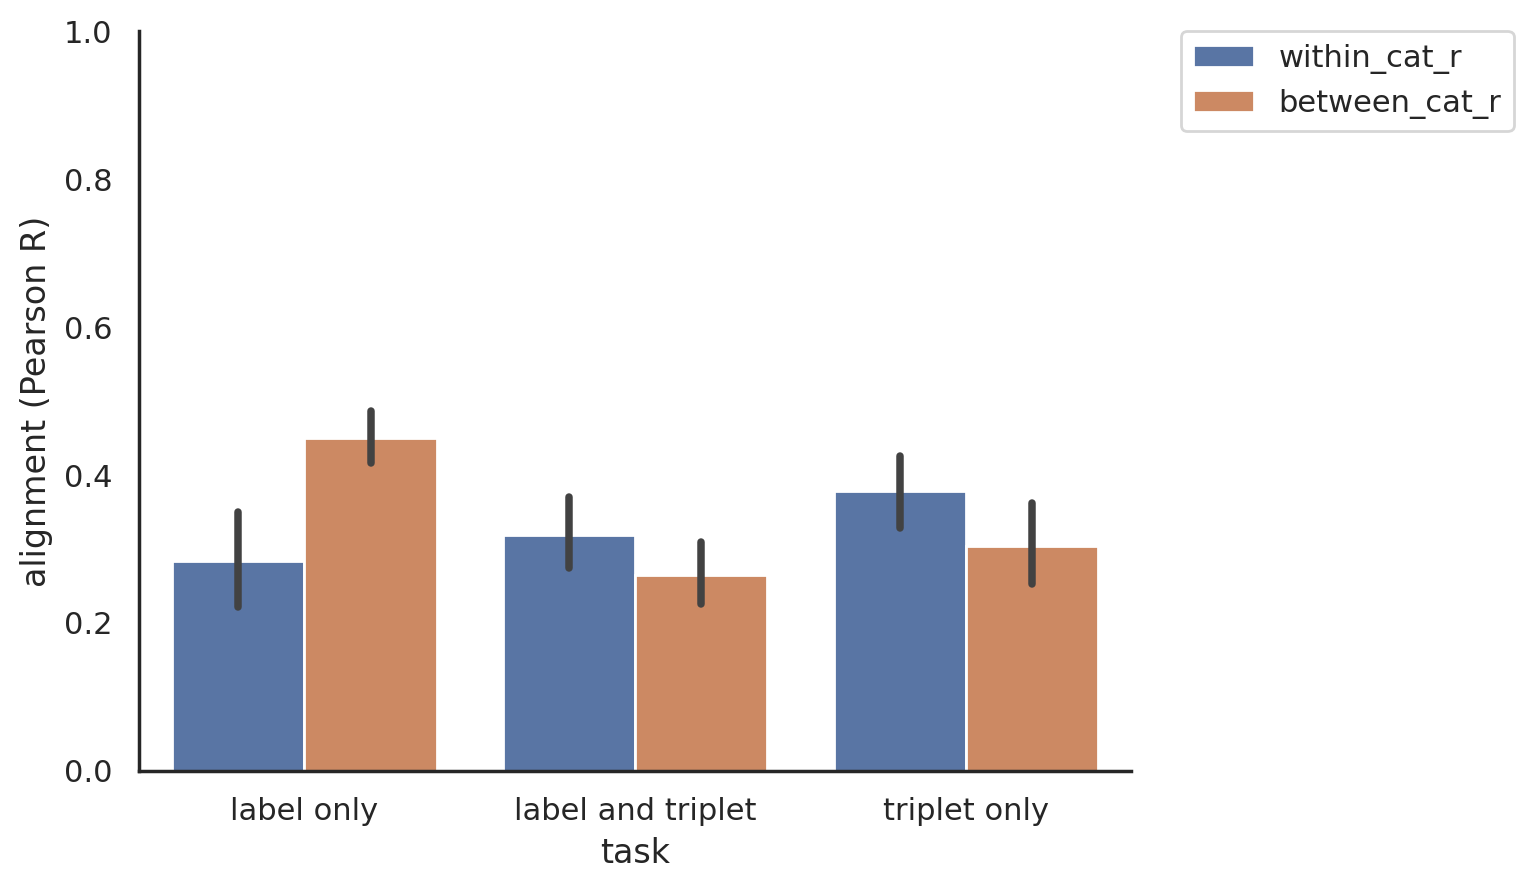

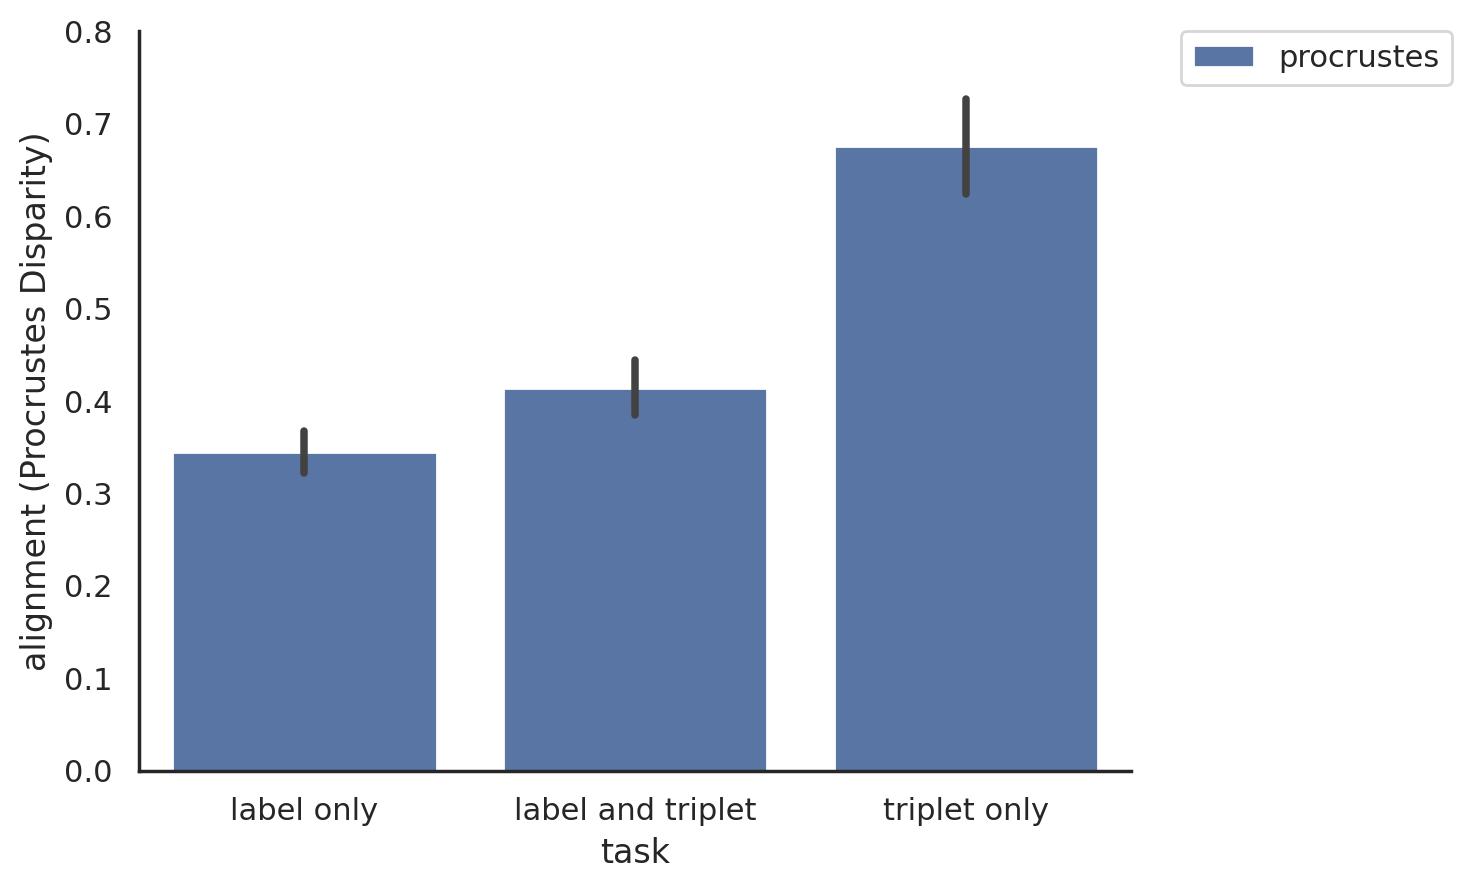

In [83]:

sns.set_theme(style="white")
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['within_cat_r','between_cat_r' ], data=sim_df_long)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Pearson R)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,1])
plt.show()
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['procrustes'], data=sim_df_long)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Procrustes Disparity)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,.8])
plt.savefig('alignment_barplot.pdf',dpi=300, bbox_inches='tight')
# plt.ylim([0,1])
plt.show()

/mnt/ws/home/kmukherjee/miniconda3/envs/sketch_tools/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


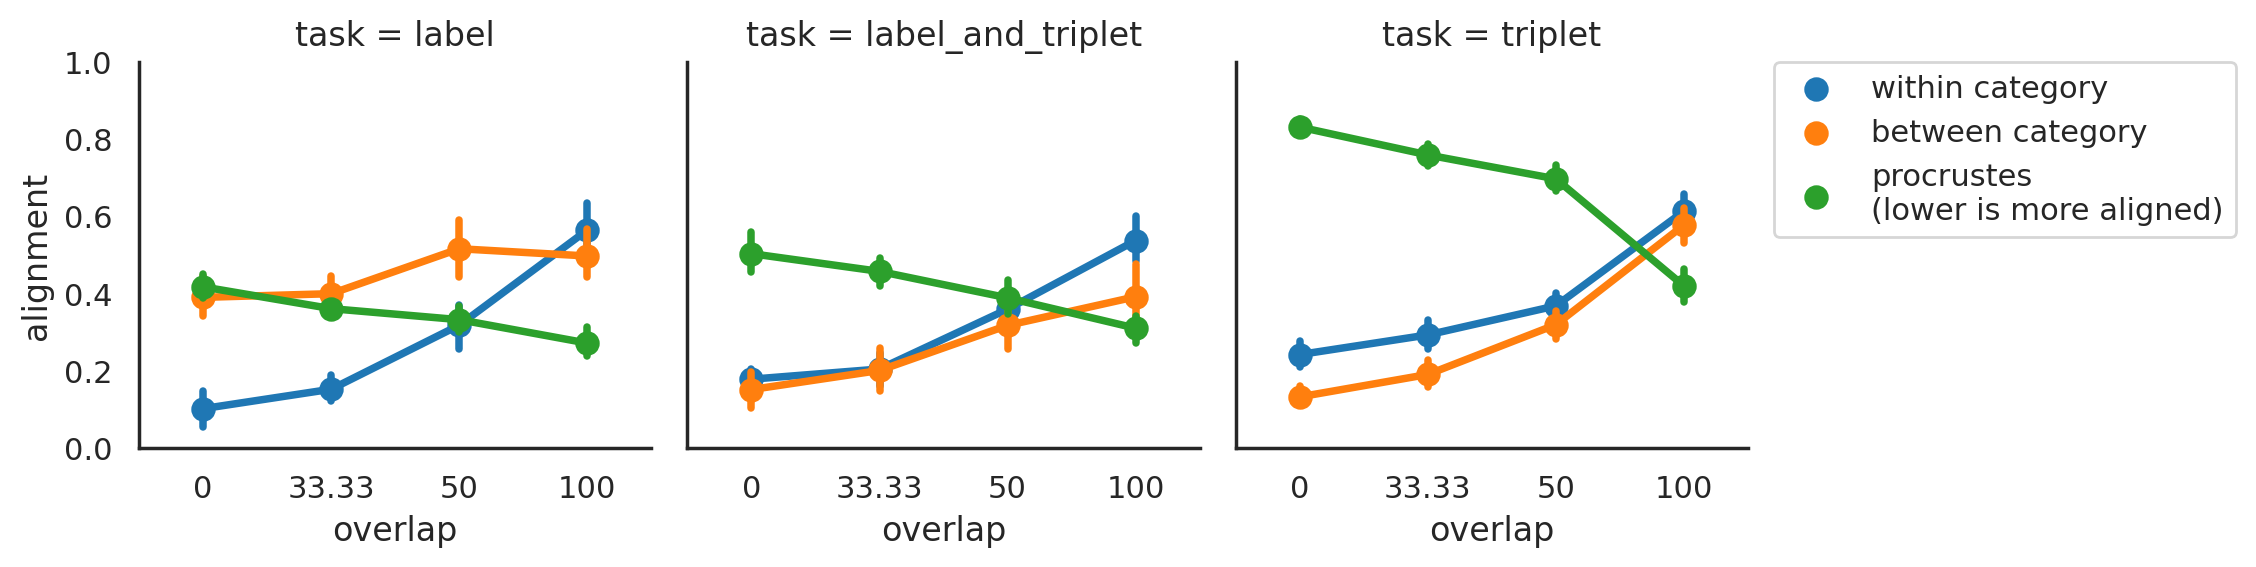

In [84]:
sns.set_theme(style="white")
# sns.pointplot(x="overlap", y="similarity", hue='category', data=sim_df)
# plt.ylim([0,1])
g = sns.FacetGrid(sim_df_long,  col="task", margin_titles=True)
ax= g.map(sns.pointplot, "overlap", "alignment", "dist_type", order=[0,33.33,50,100],palette='tab10')
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
##change the legend labels in l to be more descriptive
l.get_texts()[0].set_text('within category')
l.get_texts()[1].set_text('between category')
l.get_texts()[2].set_text('procrustes\n(lower is more aligned)')

g.set(ylim=(0, 1))


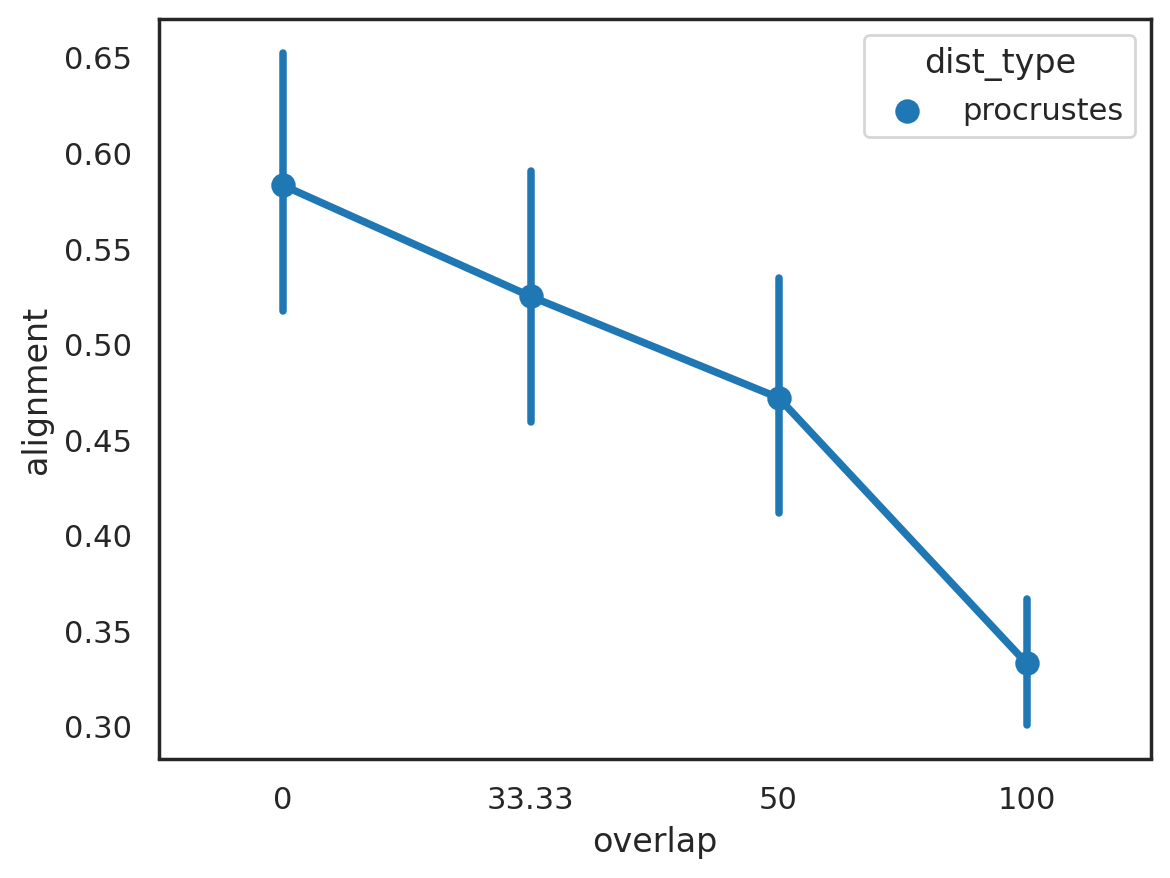

In [85]:
sns.pointplot(data= sim_df_long, x="overlap", y="alignment",hue= "dist_type", hue_order=['procrustes'],order=[0,33.33,50,100],palette='tab10')
plt.savefig('alignment_pointplot.pdf',dpi=300, bbox_inches='tight')

In [86]:
pearsonr([52,212,93,0,0,0,0],[41,5,69,0,0,0,0])

(0.2835345662954648, 0.5377692062081989)